In [0]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!unzip -q gdrive/My\ Drive/algonauts/algonauts-master.zip -d .
!mv algonauts-master/* .
!unzip -q gdrive/My\ Drive/algonauts/algonauts-dataset.zip -d /content/
!cp -r gdrive/My\ Drive/algonauts/prednet-rdms /content/

In [0]:
import h5py
import numpy as np
from scipy import stats
from scipy.spatial.distance import squareform
from scipy import io
import os
import glob
import re
import pandas as pd
from tqdm import tqdm
import zipfile

In [0]:
#defines the noise ceiling squared correlation values for EVC and IT, for the training (92, 118) and test (78) image sets 
nc92_EVC_R2 = 0.1589
nc92_IT_R2 = 0.3075
nc92_avg_R2 = (nc92_EVC_R2+nc92_IT_R2)/2.

nc118_EVC_R2 = 0.1048
nc118_IT_R2 = 0.0728
nc118_avg_R2 = (nc118_EVC_R2+nc118_IT_R2)/2.

nc78_EVC_R2 = 0.0640
nc78_IT_R2 = 0.0647
nc78_avg_R2 = (nc78_EVC_R2+nc78_IT_R2)/2.

# defines the noise ceiling squared correlation values for early and late time intervals, for the training (92, 118) and test (78) image sets
nc92_early_R2 = 0.4634
nc92_late_R2 = 0.2275
nc92_avg_R2 = (nc92_early_R2+nc92_late_R2)/2.

nc118_early_R2 = 0.3468
nc118_late_R2 = 0.2265
nc118_avg_R2 = (nc118_early_R2+nc118_late_R2)/2.

nc78_early_R2 = 0.3562 
nc78_late_R2 = 0.4452 
nc78_avg_R2 = (nc78_early_R2+nc78_late_R2)/2.

def loadmat(matfile):
    try:
        f = h5py.File(matfile)
    except (IOError, OSError):
        return io.loadmat(matfile)
    else:
        return {name: np.transpose(f.get(name)) for name in f.keys()}

def loadnpy(npyfile):
    return np.load(npyfile)

def load(data_file):
    root, ext = os.path.splitext(data_file)
    return {'.npy': loadnpy,
            '.mat': loadmat
            }.get(ext, loadnpy)(data_file)

def sq(x):
    return squareform(x, force='tovector', checks=False)

#defines the spearman correlation
def spearman(model_rdm, rdms):
    model_rdm_sq = sq(model_rdm)
    return [stats.spearmanr(sq(rdm), model_rdm_sq)[0] for rdm in rdms]

#computes spearman correlation (R) and R^2, and ttest for p-value.
def fmri_rdm(model_rdm, fmri_rdms):
    corr = spearman(model_rdm, fmri_rdms)
    corr_squared = np.square(corr)
    return np.mean(corr_squared), stats.ttest_1samp(corr_squared, 0)[1]

def evaluate(submission, targets, target_names=['EVC_RDMs', 'IT_RDMs']):
    out = {name: fmri_rdm(submission[name], targets[name]) for name in target_names}
    out['score'] = np.mean([x[0] for x in out.values()])
    return out

def meg_rdm(model_rdm, meg_rdms):
    corr = np.mean([spearman(model_rdm, rdms) for rdms in meg_rdms], 1)
    corr_squared = np.square(corr)
    return np.mean(corr_squared), stats.ttest_1samp(corr_squared, 0)[1]

def evaluate_meg(submission, targets, target_names=['MEG_RDMs_early', 'MEG_RDMs_late']):
    out = {name: meg_rdm(submission[name], targets[name]) for name in target_names}
    out['score'] = np.mean([x[0] for x in out.values()])
    return out
  
def evaluate_models(rdms_path, target_fmri_path, target_meg_path, 
                    nc_EVC_R2=nc92_EVC_R2, nc_IT_R2=nc92_IT_R2, 
                    nc_early_R2=nc92_early_R2, nc_late_R2=nc92_late_R2):
  
    target_fmri = load(target_fmri_path)
    target_meg = load(target_meg_path)
    scores_fmri = []
    scores_meg = []
    
    nc_frmi_avg_R2 = (nc_EVC_R2 + nc_IT_R2) / 2.
    nc_meg_avg_R2 = (nc_early_R2 + nc_late_R2) / 2.
    
    for submission_path in tqdm(glob.glob(os.path.join(rdms_path, '*', 'pearson'))):
        model = {}
        pattern = r'^' + os.path.join(rdms_path, '([\d\w]+)', 'pearson')
        model_name = re.search(pattern, submission_path).group(1)
        
        for submission_file in glob.glob(os.path.join(submission_path, '*', '*.mat')):
            pattern = r'^' + os.path.join(submission_path, '([\d\w]+)', 'submit_([\d\w]+)\.mat')
            layer_name = re.search(pattern, submission_file).group(1)
            submission_data = {}
            
            if 'timestep_' in layer_name:
                layer_name, timestep = layer_name.split('timestep_')
                submission_data['timestep'] = timestep
            
            submission_data['layer_name'] = layer_name
            submission_data['model_name'] = model_name
            
            data_type = re.search(pattern, submission_file).group(2)
            submission_data[f'rdm_{data_type}'] = submission_file
            submission = load(submission_file)
            
            if data_type == 'fmri':
                result = evaluate(submission, target_fmri)
                submission_data['EVC_RDMs_score'] = result['EVC_RDMs'][0]
                submission_data['EVC_RDMs_significance'] = result['EVC_RDMs'][1]
                submission_data['IT_RDMs_score'] = result['IT_RDMs'][0]
                submission_data['IT_RDMs_significance'] = result['IT_RDMs'][1]
                submission_data['fmri_score'] = result['score']
                submission_data['EVC_normalized'] = (result['EVC_RDMs'][0] / nc_EVC_R2) * 100.
                submission_data['IT_normalized'] = (result['IT_RDMs'][0] / nc_IT_R2) * 100.
                submission_data['fmri_score_normalized'] = (result['score'] / nc_frmi_avg_R2) * 100.
                scores_fmri.append(submission_data)
                
            elif data_type == 'meg':
                result = evaluate_meg(submission, target_meg)
                submission_data['MEG_RDMs_early_score'] = result['MEG_RDMs_early'][0]
                submission_data['MEG_RDMs_early_significance'] = result['MEG_RDMs_early'][1]
                submission_data['MEG_RDMs_late_score'] = result['MEG_RDMs_late'][0]
                submission_data['MEG_RDMs_late_significance'] = result['MEG_RDMs_late'][1]
                submission_data['meg_score'] = result['score']
                submission_data['Early_normalized'] = (result['MEG_RDMs_early'][0] / nc_early_R2) * 100.
                submission_data['Late_normalized'] = (result['MEG_RDMs_late'][0] / nc_late_R2) * 100.
                submission_data['meg_score_normalized'] = (result['score'] / nc_meg_avg_R2) * 100.
                scores_meg.append(submission_data)
            
    return scores_fmri, scores_meg

In [0]:
target_fmri = load('/content/Training_Data/92_Image_Set/target_fmri.mat')
target_meg = load('/content/Training_Data/92_Image_Set/target_meg.mat')

In [0]:
submit = load('/content/prednet-rdms/92images/prednet_moments__model__4_layers_epoch_1/pearson/prednet_2_timestep_9/submit_fmri.mat')
evaluate(submit, target_fmri)

In [0]:
scores_fmri, scores_meg = evaluate_models('/content/results/rdms/92images/', #'/content/prednet-rdms/92images/', 
                                          '/content/Training_Data/92_Image_Set/target_fmri.mat',
                                          '/content/Training_Data/92_Image_Set/target_meg.mat')
fmri_results = pd.DataFrame.from_dict(scores_fmri)
meg_results = pd.DataFrame.from_dict(scores_meg)
print(fmri_results.shape, meg_results.shape)

100%|██████████| 2/2 [02:13<00:00, 66.74s/it]

(72, 12) (72, 12)


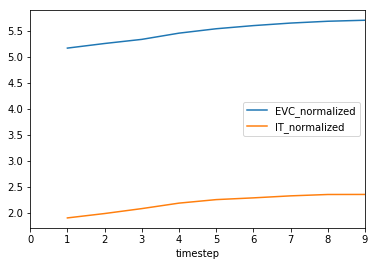

In [0]:
fmri_results[(fmri_results.model_name == 'prednet_moments__model__4_layers_epoch_1_timesteps') & \
             fmri_results.layer_name.str.contains('prednet_4')].sort_values('timestep', ascending=True)\
             .plot('timestep', ['EVC_normalized', 'IT_normalized'])

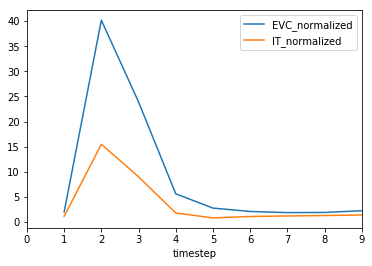

In [0]:
fmri_results[(fmri_results.model_name == 'prednet_moments__model__4_layers_epoch_1_timesteps') & \
             fmri_results.layer_name.str.contains('prednet_3')].sort_values('timestep', ascending=True)\
             .plot('timestep', ['EVC_normalized', 'IT_normalized'])

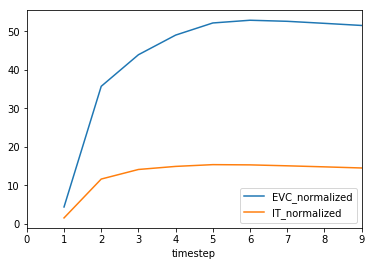

In [0]:
fmri_results[(fmri_results.model_name == 'prednet_moments__model__4_layers_epoch_1_timesteps') & \
             fmri_results.layer_name.str.contains('prednet_2')].sort_values('timestep', ascending=True)\
             .plot('timestep', ['EVC_normalized', 'IT_normalized'])

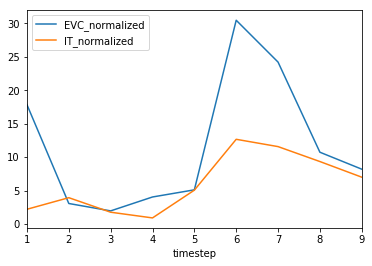

In [0]:
fmri_results[(fmri_results.model_name == 'prednet_moments_fmri_it_rdm') & \
             fmri_results.layer_name.str.contains('prednet_4')].sort_values('timestep', ascending=True)\
             .plot('timestep', ['EVC_normalized', 'IT_normalized'])

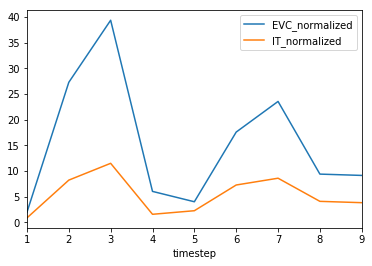

In [0]:
fmri_results[(fmri_results.model_name == 'prednet_moments_fmri_it_rdm') & \
             fmri_results.layer_name.str.contains('prednet_3')].sort_values('timestep', ascending=True)\
             .plot('timestep', ['EVC_normalized', 'IT_normalized'])

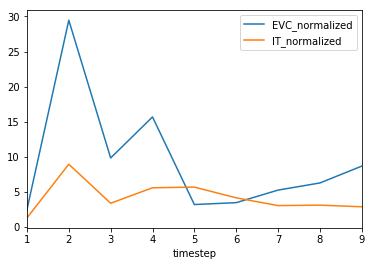

In [0]:
fmri_results[(fmri_results.model_name == 'prednet_moments_fmri_it_rdm') & \
             fmri_results.layer_name.str.contains('prednet_2')].sort_values('timestep', ascending=True)\
             .plot('timestep', ['EVC_normalized', 'IT_normalized'])

In [0]:
fmri_results.sort_values('fmri_score', ascending=False)[['model_name', 'layer_name', 
                                                         'EVC_normalized', 
                                                         'IT_normalized', 
                                                         'fmri_score_normalized', 
                                                         'EVC_RDMs_significance', 
                                                         'IT_RDMs_significance']].head(50)

,model_name,layer_name,EVC_normalized,IT_normalized,fmri_score_normalized,EVC_RDMs_significance,IT_RDMs_significance
108,prednet_moments__model__4_layers_epoch_1_times...,prednet_2_timestep_6,52.835319,15.330116,28.107940,0.000989,0.005749
113,prednet_moments__model__4_layers_epoch_1_times...,prednet_2_timestep_5,52.129347,15.390941,27.907520,0.001039,0.004722
98,prednet_moments__model__4_layers_epoch_1_times...,prednet_2_timestep_7,52.559020,15.087033,27.853540,0.000989,0.006568
109,prednet_moments__model__4_layers_epoch_1_times...,prednet_2_timestep_8,52.031540,14.816290,27.495328,0.001014,0.007170
105,prednet_moments__model__4_layers_epoch_1_times...,prednet_2_timestep_9,51.482413,14.524325,27.115749,0.001054,0.007603
52,prednet_moments__model__4_layers_epoch_1,prednet_2_timestep_9,51.482413,14.524325,27.115749,0.001054,0.007603
104,prednet_moments__model__4_layers_epoch_1_times...,prednet_2_timestep_4,48.982895,14.933282,26.533804,0.001143,0.003609
35,prednet_kitti__moments__model__10c,prednet_3_timestep_9,47.034178,15.267640,26.090330,0.000661,0.002785
117,prednet_moments__model__4_layers_epoch_1_times...,prednet_2_timestep_3,43.889059,14.136351,24.272940,0.001317,0.002306
120,prednet_moments__model__4_layers_epoch_1_times...,prednet_3_timestep_2,40.174170,15.494420,23.902679,0.000833,0.001973


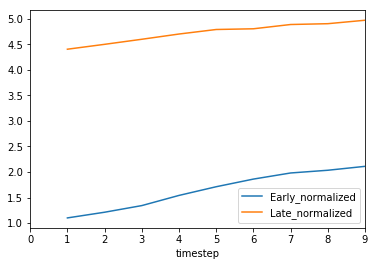

In [0]:
meg_results[(meg_results.model_name == 'prednet_moments__model__4_layers_epoch_1_timesteps') & \
             fmri_results.layer_name.str.contains('prednet_4')].sort_values('timestep', ascending=True)\
             .plot('timestep', ['Early_normalized', 'Late_normalized'])

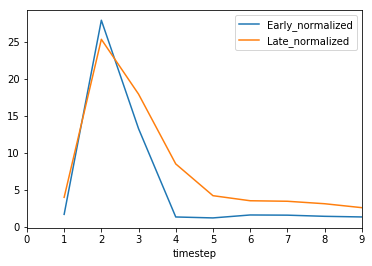

In [0]:
meg_results[(meg_results.model_name == 'prednet_moments__model__4_layers_epoch_1_timesteps') & \
             fmri_results.layer_name.str.contains('prednet_3')].sort_values('timestep', ascending=True)\
             .plot('timestep', ['Early_normalized', 'Late_normalized'])

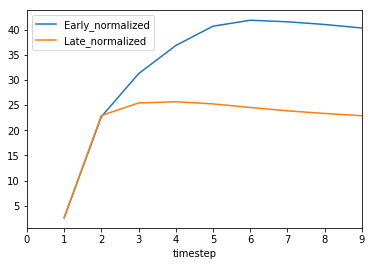

In [0]:
meg_results[(meg_results.model_name == 'prednet_moments__model__4_layers_epoch_1_timesteps') & \
             fmri_results.layer_name.str.contains('prednet_2')].sort_values('timestep', ascending=True)\
             .plot('timestep', ['Early_normalized', 'Late_normalized'])

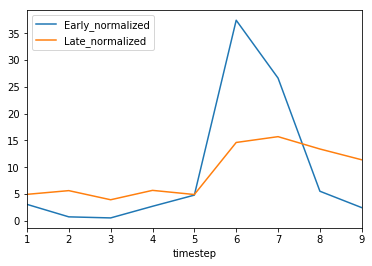

In [0]:
meg_results[(meg_results.model_name == 'prednet_moments_fmri_it_rdm') & \
             fmri_results.layer_name.str.contains('prednet_4')].sort_values('timestep', ascending=True)\
             .plot('timestep', ['Early_normalized', 'Late_normalized'])

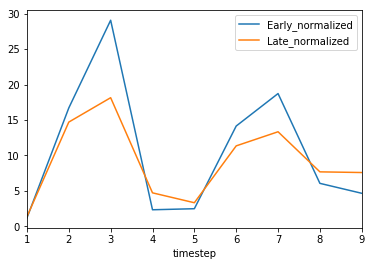

In [0]:
meg_results[(meg_results.model_name == 'prednet_moments_fmri_it_rdm') & \
             fmri_results.layer_name.str.contains('prednet_3')].sort_values('timestep', ascending=True)\
             .plot('timestep', ['Early_normalized', 'Late_normalized'])

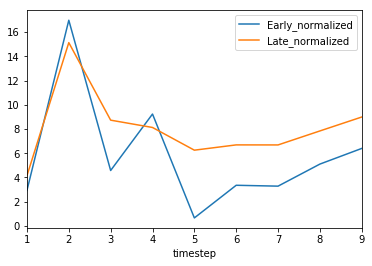

In [0]:
meg_results[(meg_results.model_name == 'prednet_moments_fmri_it_rdm') & \
             fmri_results.layer_name.str.contains('prednet_2')].sort_values('timestep', ascending=True)\
             .plot('timestep', ['Early_normalized', 'Late_normalized'])

In [0]:
meg_results.sort_values('meg_score', ascending=False)[['model_name', 'layer_name', 
                                                       'Early_normalized', 
                                                       'Late_normalized', 
                                                       'meg_score_normalized', 'MEG_RDMs_early_significance',
                                                       'MEG_RDMs_late_significance']].head(50)

,model_name,layer_name,Early_normalized,Late_normalized,meg_score_normalized,MEG_RDMs_early_significance,MEG_RDMs_late_significance
108,prednet_moments__model__4_layers_epoch_1_times...,prednet_2_timestep_6,41.889299,24.533953,36.174519,9.846091e-08,0.001293
98,prednet_moments__model__4_layers_epoch_1_times...,prednet_2_timestep_7,41.581791,23.867967,35.748972,1.030510e-07,0.001225
113,prednet_moments__model__4_layers_epoch_1_times...,prednet_2_timestep_5,40.703675,25.240700,35.612017,1.099565e-07,0.001308
109,prednet_moments__model__4_layers_epoch_1_times...,prednet_2_timestep_8,41.045972,23.342993,35.216724,1.028641e-07,0.001158
105,prednet_moments__model__4_layers_epoch_1_times...,prednet_2_timestep_9,40.345856,22.891022,34.598317,9.981417e-08,0.001071
52,prednet_moments__model__4_layers_epoch_1,prednet_2_timestep_9,40.345856,22.891022,34.598317,9.981417e-08,0.001071
104,prednet_moments__model__4_layers_epoch_1_times...,prednet_2_timestep_4,36.855738,25.673350,33.173594,1.570259e-07,0.001286
67,prednet_moments_fmri_it_rdm,prednet_4_timestep_6,37.430311,14.624411,29.920770,6.089148e-10,0.000663
117,prednet_moments__model__4_layers_epoch_1_times...,prednet_2_timestep_3,31.245228,25.432402,29.331177,2.642023e-07,0.001063
60,prednet_kitti__moments__model__3c,prednet_1_timestep_9,32.728713,18.057249,27.897684,9.405072e-10,0.000300


In [0]:
# fmri_results.iloc[fmri_results.fmri_score.idxmax()]
fmri_results.sort_values('fmri_score', ascending=False)[['model_name', 'layer_name', 
                                                         'EVC_RDMs_score', 
                                                         'IT_RDMs_score', 
                                                         'fmri_score']].head(20)

,model_name,layer_name,EVC_RDMs_score,IT_RDMs_score,fmri_score
81,prednet_moments_4_layers_epoch_1,rep_2,0.081805,0.044662,0.063234
38,prednet_finetuned_10c,rep_3,0.074737,0.046948,0.060843
33,prednet_finetuned_3c,rep_3,0.062650,0.038124,0.050387
35,prednet_finetuned_3c,rep_all,0.062650,0.038124,0.050387
36,prednet_finetuned_3c,rep_1,0.060731,0.039271,0.050001
55,prednet_finetuned_10c__5_timesteps,rep_all,0.058268,0.041650,0.049959
53,prednet_finetuned_10c__5_timesteps,rep_3,0.058268,0.041650,0.049959
30,prednet_finetuned_10c__20_timesteps,rep_all,0.059040,0.035038,0.047039
28,prednet_finetuned_10c__20_timesteps,rep_3,0.059040,0.035038,0.047039
41,prednet_finetuned_10c,rep_1,0.055489,0.036898,0.046194


In [0]:
meg_results.sort_values('meg_score', ascending=False)[['model_name', 'layer_name', 
                                                       'MEG_RDMs_early_score', 
                                                       'MEG_RDMs_late_score', 
                                                       'meg_score']].head(20)

,model_name,layer_name,MEG_RDMs_early_score,MEG_RDMs_late_score,meg_score
81,prednet_moments_4_layers_epoch_1,rep_2,0.186962,0.052077,0.119520
36,prednet_finetuned_3c,rep_1,0.151665,0.041080,0.096373
38,prednet_finetuned_10c,rep_3,0.149329,0.038179,0.093754
33,prednet_finetuned_3c,rep_3,0.118232,0.046365,0.082298
35,prednet_finetuned_3c,rep_all,0.118232,0.046365,0.082298
53,prednet_finetuned_10c__5_timesteps,rep_3,0.123665,0.037261,0.080463
55,prednet_finetuned_10c__5_timesteps,rep_all,0.123665,0.037261,0.080463
41,prednet_finetuned_10c,rep_1,0.126154,0.032818,0.079486
34,prednet_finetuned_3c,rep_2,0.119320,0.038994,0.079157
54,prednet_finetuned_10c__5_timesteps,rep_2,0.103087,0.035327,0.069207


## Generating combined submissions

In [0]:
submit_evc = load('/content/prednet-rdms/78images/prednet_kitti__moments__model__10c/pearson/prednet_3_timestep_9/submit_fmri.mat')
submit_it = load('/content/prednet-rdms/78images/prednet_moments_fmri_it_rdm/pearson/prednet_4_timestep_9/submit_fmri.mat')
submit_evc['EVC_RDMs'], submit_it['IT_RDMs']
rdm_fmri = {
    'EVC_RDMs': submit_evc['EVC_RDMs'],
    'IT_RDMs': submit_it['IT_RDMs']
}

RDM_dir = '/content/prednet-rdms/78images/best_fmri'
if not os.path.exists(RDM_dir):
    os.makedirs(RDM_dir)
    
RDM_filename_fmri = os.path.join(RDM_dir,'submit_fmri.mat')
RDM_filename_fmri_zip = os.path.join(RDM_dir,'submit_fmri.zip')
io.savemat(RDM_filename_fmri, rdm_fmri)
        
#creating zipped file for submission
zipfmri = zipfile.ZipFile(RDM_filename_fmri_zip, 'w')
zipfmri.write(os.path.join(RDM_dir,'submit_fmri.mat'), 'submit_fmri.mat')
zipfmri.close()

In [0]:
submit_early = load('/content/prednet-rdms/78images/prednet_kitti__moments__model__3c/pearson/prednet_3_timestep_9/submit_meg.mat')
submit_late = load('/content/prednet-rdms/78images/prednet_moments_fmri_it_rdm__alexnet/pearson/prednet_4_timestep_9__conv4/submit_meg.mat')

rdm_meg = {
    'MEG_RDMs_late': submit_late['MEG_RDMs_late'],
    'MEG_RDMs_early': submit_early['MEG_RDMs_early']
}

RDM_dir = '/content/prednet-rdms/78images/best_meg'
if not os.path.exists(RDM_dir):
    os.makedirs(RDM_dir)
    
RDM_filename_meg = os.path.join(RDM_dir,'submit_meg.mat')
RDM_filename_meg_zip = os.path.join(RDM_dir,'submit_meg.zip')
io.savemat(RDM_filename_meg, rdm_meg)
        
#creating zipped file for submission
zipfmri = zipfile.ZipFile(RDM_filename_meg_zip, 'w')
zipfmri.write(os.path.join(RDM_dir,'submit_meg.mat'), 'submit_meg.mat')
zipfmri.close()